We'll be implementing the research paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale": https://arxiv.org/abs/2010.11929

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms 
from torchinfo import summary 

from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

c:\Users\alexa\Documents\Uni\Personal Projects\Pytorch-Fundamentals\Pytorch-Course\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu" 
device

'cuda'

In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [4]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [5]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1784ab61910>,
 ['pizza', 'steak', 'sushi'])

In [7]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

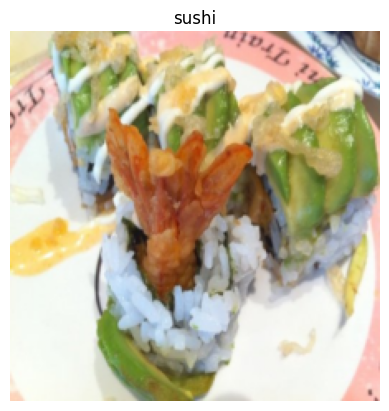

In [8]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [9]:
# Create some example values
height = 224 # H
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [10]:
# input shape (size of single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


(-0.5, 223.5, 223.5, -0.5)

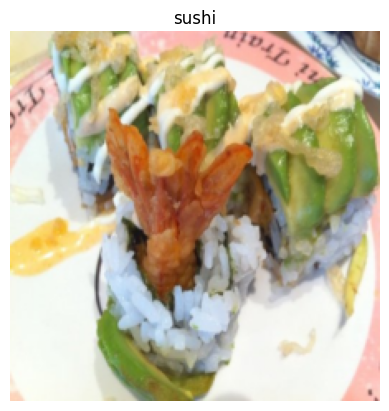

In [11]:
# Let's view a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

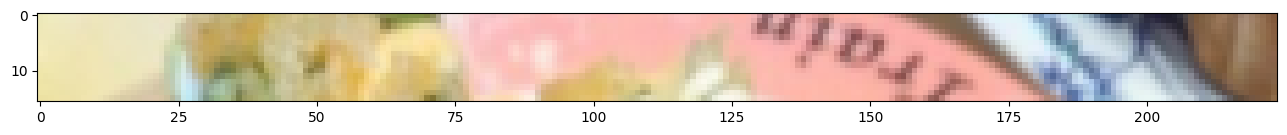

In [12]:
image_permuted = image.permute(1, 2, 0)

patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[: patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


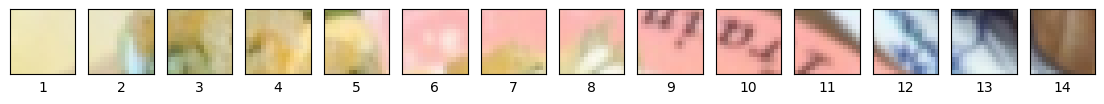

In [13]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


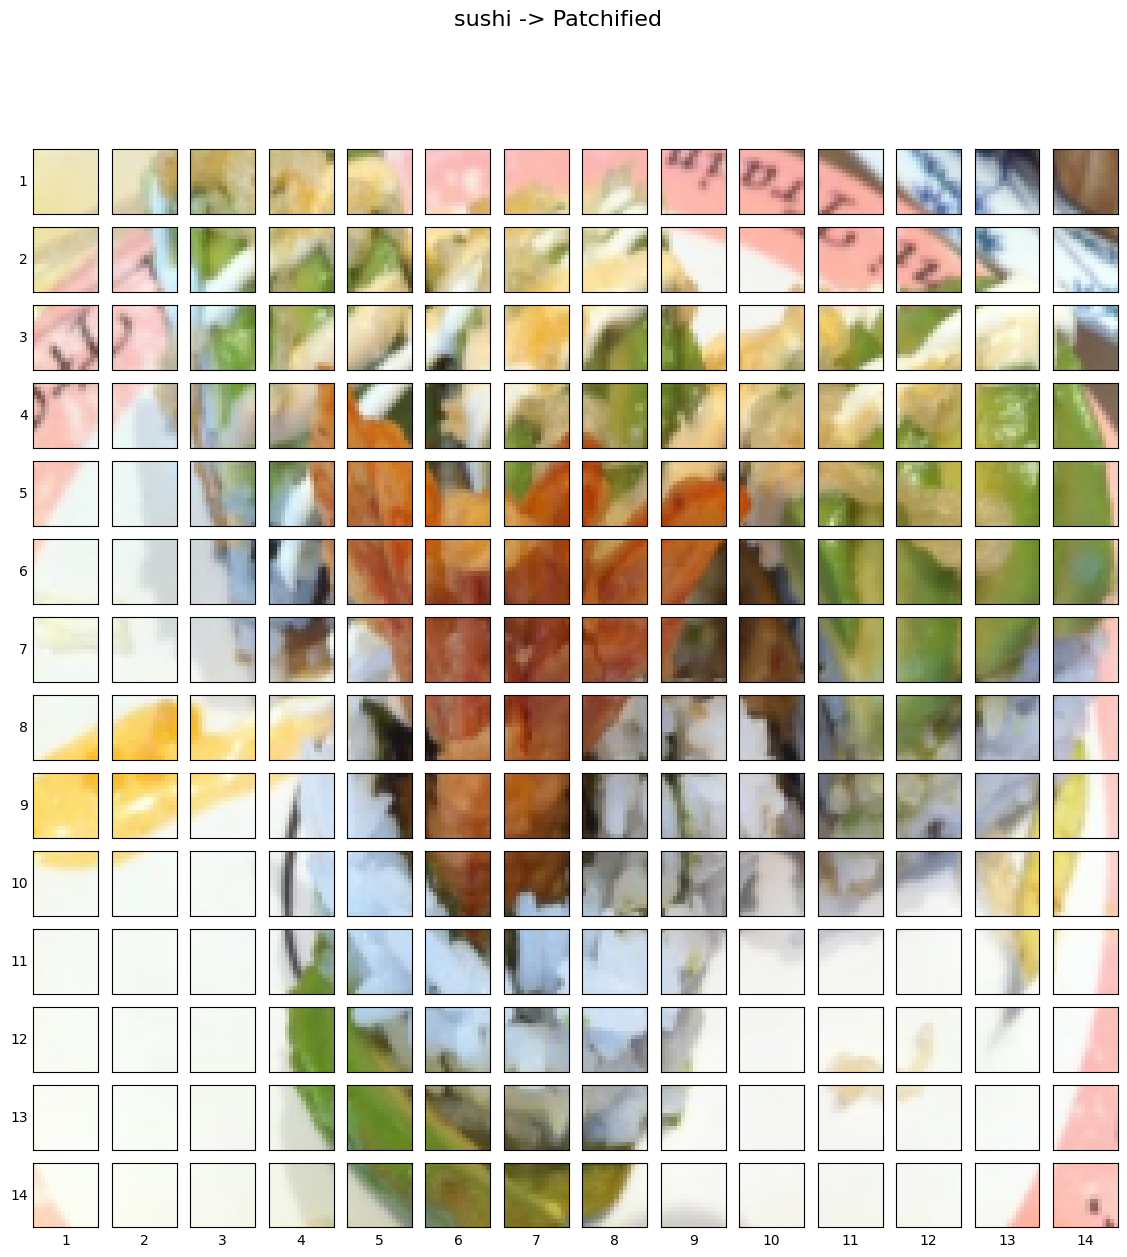

In [14]:
# Let's iterate through the whole picture
img_size = 224
patch_size = 16
num_patches = img_size / patch_size

assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [15]:
from torch import nn 

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

(-0.5, 223.5, 223.5, -0.5)

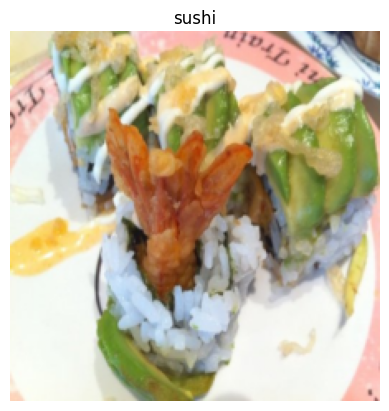

In [16]:
# Let's view an image
plt.imshow(image_permuted)
plt.title(class_names[label])
plt.axis(False)

In [17]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [337, 10, 250, 644, 281]


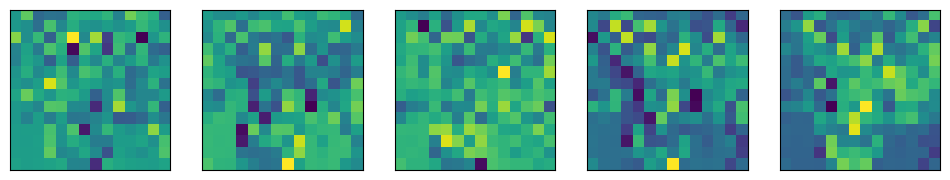

In [18]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 768), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [19]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[0.9486, 0.7824, 0.7765, 0.8025, 1.0227, 0.9914, 0.9403, 0.8734,
           0.8124, 0.8220, 0.8760, 0.8249, 0.2498, 0.5782],
          [0.9273, 0.7295, 0.7273, 0.7708, 0.6511, 0.8580, 0.8222, 0.8463,
           0.9491, 0.8920, 0.9632, 0.8602, 0.8374, 0.6559],
          [0.9374, 0.8933, 0.5433, 0.7087, 0.7789, 0.7912, 0.9012, 0.7092,
           1.0757, 0.8606, 0.7359, 0.8066, 1.0270, 0.8113],
          [0.8322, 0.8262, 0.6345, 0.7697, 0.6915, 0.8398, 0.8149, 0.6023,
           0.6546, 0.8015, 1.0311, 0.7044, 0.5865, 0.5760],
          [1.0238, 0.9183, 0.6663, 0.7278, 0.7199, 0.7128, 0.5742, 0.5881,
           0.7101, 0.6677, 0.7223, 0.6347, 0.7044, 0.6041],
          [0.9864, 0.8671, 0.7004, 0.5975, 0.6149, 0.7766, 0.5839, 0.5572,
           0.6095, 0.3115, 0.5300, 0.6487, 0.5342, 0.5176],
          [0.9500, 0.9281, 0.7823, 0.3526, 0.6945, 0.5740, 0.4577, 0.5511,
           0.4333, 0.3795, 0.4999, 0.5126, 0.4382, 0.7006],
          [1.0432, 0.8587, 0.9661, 0.9263, 0.6644, 0.49

In [20]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


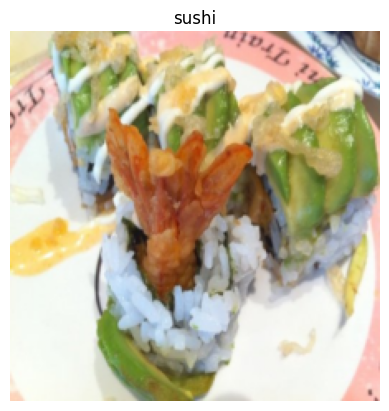

In [21]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [22]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


(-0.5, 195.5, 0.5, -0.5)

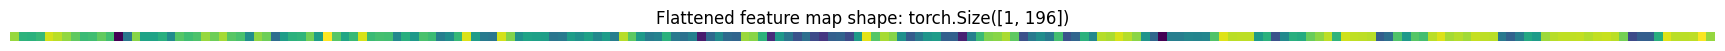

In [23]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

In [24]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[0.9486, 0.7824, 0.7765, 0.8025, 1.0227, 0.9914, 0.9403, 0.8734, 0.8124,
          0.8220, 0.8760, 0.8249, 0.2498, 0.5782, 0.9273, 0.7295, 0.7273, 0.7708,
          0.6511, 0.8580, 0.8222, 0.8463, 0.9491, 0.8920, 0.9632, 0.8602, 0.8374,
          0.6559, 0.9374, 0.8933, 0.5433, 0.7087, 0.7789, 0.7912, 0.9012, 0.7092,
          1.0757, 0.8606, 0.7359, 0.8066, 1.0270, 0.8113, 0.8322, 0.8262, 0.6345,
          0.7697, 0.6915, 0.8398, 0.8149, 0.6023, 0.6546, 0.8015, 1.0311, 0.7044,
          0.5865, 0.5760, 1.0238, 0.9183, 0.6663, 0.7278, 0.7199, 0.7128, 0.5742,
          0.5881, 0.7101, 0.6677, 0.7223, 0.6347, 0.7044, 0.6041, 0.9864, 0.8671,
          0.7004, 0.5975, 0.6149, 0.7766, 0.5839, 0.5572, 0.6095, 0.3115, 0.5300,
          0.6487, 0.5342, 0.5176, 0.9500, 0.9281, 0.7823, 0.3526, 0.6945, 0.5740,
          0.4577, 0.5511, 0.4333, 0.3795, 0.4999, 0.5126, 0.4382, 0.7006, 1.0432,
          0.8587, 0.9661, 0.9263, 0.6644, 0.4901, 0.5832, 0.6793, 0.7043, 0.5028,
          0.5071

In [26]:
# Create a class for patchembedding
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
    in_channels (int): Number of color channels for the input images. Defaults to 3.
    patch_size (int): Size of patches to convert input image into. Defaults to 16.
    embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    def __init__(self, in_channels: int=3, patch_size: int=16, embedding_dim: int=768):
        super().__init__()

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                    out_channels=embedding_dim,
                                    kernel_size=patch_size,
                                    stride=patch_size,
                                    padding=0)
        
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        # Create assertion for correct shapes
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1)       
     

In [27]:
set_seeds()

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [30]:
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250)

summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [31]:
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")


tensor([[[-0.9168,  0.2429, -0.2294,  ...,  0.6771, -0.4509,  0.3483],
         [-0.7427,  0.1953, -0.3559,  ...,  0.5824, -0.3451,  0.3274],
         [-0.7598,  0.2608, -0.1681,  ...,  0.5895, -0.3979,  0.0758],
         ...,
         [-1.0077,  0.2796, -0.2795,  ...,  0.7628, -0.4584,  0.3580],
         [-0.9839,  0.1649, -0.1600,  ...,  0.7498, -0.5472,  0.3500],
         [-0.9262,  0.1364, -0.1151,  ...,  0.5843, -0.4750,  0.3103]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [32]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)

print(class_token[:, :, :10])

print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [33]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.9168,  0.2429, -0.2294,  ...,  0.6771, -0.4509,  0.3483],
         [-0.7427,  0.1953, -0.3559,  ...,  0.5824, -0.3451,  0.3274],
         ...,
         [-1.0077,  0.2796, -0.2795,  ...,  0.7628, -0.4584,  0.3580],
         [-0.9839,  0.1649, -0.1600,  ...,  0.7498, -0.5472,  0.3500],
         [-0.9262,  0.1364, -0.1151,  ...,  0.5843, -0.4750,  0.3103]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]
